# Tutorial: Using the Diarization Simulation Package

This tutorial provides a **documented example of use** of the diarization-simulation package: from installation through a complete worked example with expected outputs and interpretation. It goes beyond the README by walking you through two concrete analyses using the correlation between child and female-adult vocalization counts, **R(CHI, FEM)**: (1) examining how sensitive this quantity is to confusion errors, and (2) testing whether an observed value of R could be explained by classification errors alone.

The package and methods are described in Gautheron et al. (2025), *Classification errors distort findings in automated speech processing: examples and solutions from child-development research*.

---

## Contents

1. Quick start (5 minutes)
2. Why use this package?
3. Installation and prerequisites
4. Complete worked example: R(CHI, FEM) — sensitivity and significance
5. Step-by-step reference
6. Interpreting simulation results
7. References

---

## Quick start (5 minutes)

If you want to see the package in action immediately:

1. Create a small ground truth file `truth.csv` with columns: `observation`, `CHI`, `OCH`, `FEM`, `MAL`.
2. In a terminal: `diarization-simulate --truth truth.csv --output simulated.csv --algo vtc --samples 100 --distribution poisson --seed 42`
3. Load and inspect the output in Python (see cell below).

Each `observation` appears 100 times (one per `sample`), with different simulated counts reflecting algorithm variability and confusion.

In [37]:
# Quick check (run after creating truth.csv and running diarization-simulate)
import pandas as pd

# If you already ran the CLI, uncomment:
# sim = pd.read_csv("simulated.csv")
# sim.groupby("observation")[["CHI", "OCH", "FEM", "MAL"]].mean()

# Or create minimal truth and simulate from Python:
truth_df = pd.DataFrame({
    "observation": [1, 2, 3],
    "CHI": [120, 90, 150],
    "OCH": [30, 15, 25],
    "FEM": [200, 180, 220],
    "MAL": [50, 70, 45],
})
truth_df.to_csv("truth.csv", index=False)

from diarization_simulation import simulate_diarization
sim = simulate_diarization(truth_data=truth_df, algorithm="vtc", n_samples=50, random_seed=42, verbose=False)
sim.groupby("observation")[["CHI", "OCH", "FEM", "MAL"]].mean()

,CHI,OCH,FEM,MAL
observation,,,,
1,83.68,45.84,109.18,54.68
2,65.72,30.16,102.48,63.28
3,107.12,49.38,117.68,59.64


---

## Why use this package?

Automated diarization algorithms (LENA, VTC) segment and label speech into speaker types (CHI, OCH, FEM, MAL). Their errors—missed detections and confusions between speakers—propagate into vocalization counts and can **bias** downstream statistics (correlations, effect sizes, proportions).

**Simulations** let you:

1. Start from synthetic or real "true" vocalization counts.
2. Simulate what LENA or VTC would *measure* given those true counts (using calibration-based confusion rates from the manuscript).
3. Run your analysis on the simulated measurements and compare results to the known truth.

If simulated estimates systematically differ from the true values, your analysis is sensitive to classification bias; you may then consider Bayesian calibration or other corrections (see the manuscript).

---

## Installation and prerequisites

- **Python 3.8+**
- For **ground-truth generation from a corpus**: a [ChildProject](https://github.com/LAAC-LSCP/ChildProject)-formatted corpus with manual annotations, plus optional dependencies (see README).

From the project root:

```bash
git clone https://github.com/LAAC-LSCP/diarization-simulation.git
cd diarization-simulation
pip install -e .
```

To also use ground-truth generation: `pip install -e ".[truth]"`

Verify: `diarization-simulate --help`

---

## Complete worked example: R(CHI, FEM) — sensitivity and significance

We use the **correlation between child and female-adult vocalization counts**, R(CHI, FEM). The example has two parts:

1. **Step 1 — Sensitivity:** How much does the *measured* R(CHI, FEM) differ from the *true* R when we simulate algorithm output?
2. **Step 2 — Significance test:** You have a small corpus and observe a value of R. Could that value be due to classification errors alone (true R = 0)?

### Step 1: Examine the sensitivity of R(CHI, FEM) to confusion errors

We generate ground truth with a **known true correlation** between CHI and FEM, simulate what VTC would report, then compute the **measured** R(CHI, FEM) from the simulated counts.

#### 1.1 Generate ground truth from a multivariate log-normal

We draw vocalization counts from a **multivariate log-normal**: log(counts) ∼ MVN(μ, Σ), with Σ given by per-speaker standard deviations and a correlation matrix. Parameters: **mean_log** (mean of log(counts) per speaker), **std_log** (std per speaker), **corr_matrix** (4×4 correlation matrix). Two datasets: **CHI–FEM uncorrelated** (true R ≈ 0) and **positive CHI–FEM correlation** (true R ≈ 0.3). Each has 64 observations.

In [38]:
import numpy as np
import pandas as pd

SPEAKERS = ["CHI", "OCH", "FEM", "MAL"]

def make_ground_truth(n_obs, mean_log, std_log, corr_matrix, seed=42):
    """
    Generate ground truth: Z ~ MVN(mean_log, Sigma), then counts = Poisson(exp(Z)).
    Sigma[i,j] = std_log[i]*std_log[j]*corr_matrix[i,j].
    """
    np.random.seed(seed)
    mean_log = np.asarray(mean_log, dtype=float)
    std_log = np.asarray(std_log, dtype=float)
    corr_matrix = np.asarray(corr_matrix, dtype=float)
    D = np.diag(std_log)
    cov_log = D @ corr_matrix @ D
    Z = np.random.multivariate_normal(mean_log, cov_log, size=n_obs)
    rates = np.exp(Z)
    counts = np.random.poisson(rates).clip(min=0).astype(int)
    df = pd.DataFrame(counts, columns=SPEAKERS)
    df.insert(0, "observation", np.arange(1, n_obs + 1))
    return df

# Geometric means: CHI ~120, OCH ~30, FEM ~200, MAL ~50
mean_log = np.log([1000, 300, 2000, 500])
std_log = np.array([0.4, 0.5, 0.35, 0.5])
corr_r0 = np.eye(4)
corr_r0[0, 2] = corr_r0[2, 0] = 0.0
corr_r03 = np.eye(4)
corr_r03[0, 2] = corr_r03[2, 0] = 0.35

n_obs = 64
truth_r0 = make_ground_truth(n_obs, mean_log, std_log, corr_r0)
truth_r03 = make_ground_truth(n_obs, mean_log, std_log, corr_r03)

print("True R(CHI,FEM) when CHI–FEM uncorrelated:", truth_r0[["CHI", "FEM"]].corr().iloc[0, 1])
print("True R(CHI,FEM) when CHI–FEM correlated:  ", truth_r03[["CHI", "FEM"]].corr().iloc[0, 1])

truth_r0.to_csv("example_truth_r0.csv", index=False)
truth_r03.to_csv("example_truth_r03.csv", index=False)

True R(CHI,FEM) when CHI–FEM uncorrelated: 0.034757669775624105
True R(CHI,FEM) when CHI–FEM correlated:   0.36604919835911487


#### 1.2 Simulate VTC output and compute measured R per sample

For each ground truth we simulate 500 "measured" datasets. For each sample we compute the Pearson correlation between CHI and FEM **across observations** — that is the measured R(CHI, FEM) for that sample.

In [39]:
from diarization_simulation import simulate_diarization

n_samples = 500

sim_r0 = simulate_diarization(
    truth_data="example_truth_r0.csv",
    algorithm="vtc",
    distribution="poisson",
    n_samples=n_samples,
    random_seed=42,
    verbose=True,
)

sim_r03 = simulate_diarization(
    truth_data="example_truth_r03.csv",
    algorithm="vtc",
    distribution="poisson",
    n_samples=n_samples,
    random_seed=43,
    verbose=True,
)

def measured_r_per_sample(sim_df):
    """For each sample, compute R(CHI, FEM) across observations."""
    r_list = []
    for s in sim_df["sample"].unique():
        sub = sim_df[sim_df["sample"] == s]
        r = sub[["CHI", "FEM"]].corr().iloc[0, 1]
        r_list.append(r)
    return np.array(r_list)

R_measured_r0 = measured_r_per_sample(sim_r0)
R_measured_r03 = measured_r_per_sample(sim_r03)

INFO: Each sample will have its own hyperpriors. This captures uncertainty about the algorithm behavior.


Simulating: 100%|██████████| 500/500 [00:00<00:00, 7570.13it/s]


INFO: Each sample will have its own hyperpriors. This captures uncertainty about the algorithm behavior.


Simulating: 100%|██████████| 500/500 [00:00<00:00, 7891.06it/s]


#### 1.3 Compare measured R to true R (sensitivity)

In [40]:
print("When TRUE R(CHI,FEM) = 0:")
print("  Mean measured R:", R_measured_r0.mean())
print("  Std measured R: ", R_measured_r0.std())
print("  (Spurious correlation from confusion alone)")

print("When TRUE R(CHI,FEM) ≈ 0.3:")
print("  Mean measured R:", R_measured_r03.mean())
print("  Std measured R: ", R_measured_r03.std())
print("  (Bias: measured R vs true 0.3)")

When TRUE R(CHI,FEM) = 0:
  Mean measured R: 0.2333481590229879
  Std measured R:  0.09066332506811613
  (Spurious correlation from confusion alone)
When TRUE R(CHI,FEM) ≈ 0.3:
  Mean measured R: 0.4571301519155138
  Std measured R:  0.0767391906323695
  (Bias: measured R vs true 0.3)


**Interpretation:** Even when the true correlation is **zero**, the measured R is typically **positive** (spurious correlation from confusion). When the true R is 0.3, the measured R is often **inflated**. So R(CHI, FEM) is **sensitive** to confusion errors.

---

### Step 2: Test whether an observed R is consistent with classification errors alone

**Scenario:** You have a **small corpus** (e.g. 64 recordings). You ran VTC and computed R(CHI, FEM); you observe **R_observed = 0.39**. Could this arise **only** from classification errors (true R = 0)?

**Idea:** Under the **null** (true R = 0), simulate many VTC "measurements" and get the **null distribution** of measured R. Compare R_observed to this distribution (p-value).

#### 2.1 Assume your corpus size and observed R

In [41]:
n_obs_corpus = 64
R_observed = 0.39

#### 2.2 Generate null ground truth (true R = 0)

In [42]:
# Reuse mean_log, std_log, corr_r0 from Step 1
truth_null = make_ground_truth(n_obs_corpus, mean_log, std_log, corr_r0, seed=123)
truth_null.to_csv("example_truth_null.csv", index=False)

#### 2.3 Simulate many VTC outputs under the null

In [43]:
n_null_samples = 2000
sim_null = simulate_diarization(
    truth_data="example_truth_null.csv",
    algorithm="vtc",
    distribution="poisson",
    n_samples=n_null_samples,
    random_seed=999,
    verbose=True,
)
R_null = measured_r_per_sample(sim_null)

INFO: Each sample will have its own hyperpriors. This captures uncertainty about the algorithm behavior.


Simulating: 100%|██████████| 2000/2000 [00:00<00:00, 7507.65it/s]


#### 2.4 Compare R_observed to the null distribution and compute p-value

In [44]:
p_one_tailed = (R_null >= R_observed).mean()
p_two_tailed = (np.abs(R_null) >= np.abs(R_observed)).mean()

print("R_observed =", R_observed)
print("Null distribution: mean =", R_null.mean(), ", std =", R_null.std())
print("One-tailed p-value (H0: true R <= 0):", p_one_tailed)
print("Two-tailed p-value (H0: true R = 0):", p_two_tailed)

R_observed = 0.39
Null distribution: mean = 0.27771807698695433 , std = 0.08848379657650435
One-tailed p-value (H0: true R <= 0): 0.0985
Two-tailed p-value (H0: true R = 0): 0.0985


**Interpretation:** If p-value is **small** (e.g. < 0.05), the observed R is **not easily explained** by classification errors alone. If p-value is **large**, the observed R is **consistent** with the null (spurious correlation from algorithm errors).

#### 2.5 Optional: plot null distribution and R_observed

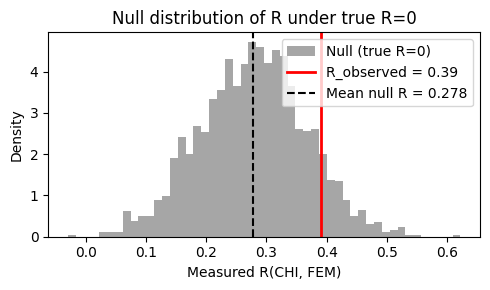

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(R_null, bins=50, density=True, alpha=0.7, color="gray", label="Null (true R=0)")
ax.axvline(R_observed, color="red", lw=2, label=f"R_observed = {R_observed}")
ax.axvline(R_null.mean(), color="black", ls="--", label=f"Mean null R = {R_null.mean():.3f}")
ax.set_xlabel("Measured R(CHI, FEM)")
ax.set_ylabel("Density")
ax.legend()
ax.set_title("Null distribution of R under true R=0")
plt.tight_layout()
plt.savefig("example_null_R_chi_fem.png", dpi=150)
plt.show()

---

### Summary of the two steps

| Step | Goal | What you do |
|------|------|-------------|
| **1. Sensitivity** | See how much R(CHI, FEM) is distorted by confusion | Generate ground truth with known true R (e.g. 0 and 0.3), simulate algorithm, compute measured R per sample; compare mean(measured R) to true R. |
| **2. Significance** | Test if an observed R could be due to errors alone | Take your corpus size and R_observed; simulate under null (true R=0), get null distribution of measured R; compute p-value. |

You can reuse the same logic for other quantities (e.g. other correlations, proportion female, effect of siblings).

---

## Step-by-step reference

**Ground truth format:** columns `observation`, `CHI`, `OCH`, `FEM`, `MAL` (non-negative integers).

**Python API:**

```python
from diarization_simulation import simulate_diarization
results = simulate_diarization(
    truth_data="truth.csv",  # or DataFrame
    algorithm="vtc",
    distribution="poisson",
    n_samples=1000,
    random_seed=42,
    hyperprior_mode="sample",  # "sample" | "average" | "unique"
)
```

**Using simulated data:** For each `sample`, run your analysis (e.g. correlation, regression); compare the distribution of estimates to the true values.

---

## Interpreting simulation results

- **Sensitivity (Step 1):** If the *mean* measured statistic differs from the true value, the quantity is biased by confusion. The *spread* across samples reflects extra uncertainty.
- **Significance (Step 2):** If your observed value falls in the tail of the null distribution (small p-value), it is not easily explained by classification errors alone; if it falls in the bulk (large p-value), it is consistent with the null.
- **Algorithm comparison:** Run the same ground truth through both `vtc` and `lena` and compare bias and null distributions.
- **Next steps:** Consider Bayesian calibration (manuscript) or reporting uncertainty; simulations **diagnose** sensitivity and test consistency with classification errors alone.

---

## References

- **Package:** [LAAC-LSCP/diarization-simulation](https://github.com/LAAC-LSCP/diarization-simulation)
- **Manuscript:** Gautheron, L., Kidd, E., Malko, A., Lavechin, M., & Cristia, A. (2025). *Classification errors distort findings in automated speech processing: examples and solutions from child-development research.* [DOI: 10.31234/osf.io/u925y](http://dx.doi.org/10.31234/osf.io/u925y)

For installation options, ground-truth generation from a ChildProject corpus, and the statistical model, see the project **README.md**.